Following [a simple but efficient real-time voice activity detection algorithm](https://www.eurasip.org/Proceedings/Eusipco/Eusipco2009/contents/papers/1569192958.pdf)

In [1]:
import math
import IPython.display as ipd
import matplotlib.pyplot as plt
import torch
import torchaudio

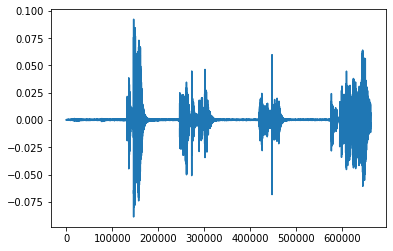

In [2]:
# Voice sound
# dataset = torchaudio.datasets.YESNO("~/yesno")
# waveform = dataset[0][0]
# sample_rate = 8 * 10**3

# Train sound
# filename = "_static/img/steam-train-whistle-daniel_simon-converted-from-mp3.wav"

# filename = "Audio_Sample_-_The_Quick_Brown_Fox_Jumps_Over_The_Lazy_Dog.wav"
# filename = "from_research_to_production.wav"
# filename = "research_to_prod_2.wav"
filename = "To-be-or-not-to-be-Kenneth-Branagh-HD-HAMLET-AudioTrimmer.com.wav"
waveform, sample_rate = torchaudio.load(filename)
# waveform = torchaudio.transforms.Resample(orig_freq=sample_rate,new_freq=16000)(waveform)
# sample_rate = 16000

# Convert to mono
waveform = waveform.mean(0)

plt.plot(waveform.t())

In [3]:
sample_rate

44100

In [4]:
torchaudio.save("sound.wav", waveform, sample_rate)
ipd.Audio("sound.wav")

In [5]:
waveform.shape

torch.Size([1, 663023])

In [6]:
waveform

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0051, 0.0052, 0.0057]])

In [7]:
waveform[...,1:]-waveform[...,:-1]

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 6.1035e-05, 9.1553e-05,
         5.0354e-04]])

# MFCC?

In [30]:
import soundfile as sf

waveform, sample_rate = sf.read(filename)

waveform = torch.from_numpy(waveform).mean(-1).unsqueeze(0).float()

waveform.shape

torch.Size([1, 663023])

In [3]:
mfcc = torchaudio.transforms.MFCC()

specgram = mfcc(waveform)
specgram

JITException: Exception
The above operation failed in interpreter, with the following stack trace:
at /Users/vincentqb/anaconda3/envs/audio/lib/python3.7/site-packages/torchaudio-0.2-py3.7-macosx-10.7-x86_64.egg/torchaudio/functional.py:193:5
        power (int): Exponent for the magnitude spectrogram,
            (must be > 0) e.g., 1 for energy, 2 for power, etc.
        normalized (bool): Whether to normalize by magnitude after stft

    Returns:
        torch.Tensor: Channels x frequency x time (c, f, t), where channels
        is unchanged, frequency is `n_fft // 2 + 1` where `n_fft` is the number of
        fourier bins, and time is the number of window hops (n_frames).
    """
    assert waveform.dim() == 2
    ~~~~~~~~~~~~~~~~~~~~~~~~~~ <--- HERE

    if pad > 0:
        # TODO add "with torch.no_grad():" back when JIT supports it
        waveform = torch.nn.functional.pad(waveform, (pad, pad), "constant")

    # default values are consistent with librosa.core.spectrum._spectrogram
    spec_f = _stft(waveform, n_fft, hop_length, win_length, window,
                   True, 'reflect', False, True)


In [47]:
mfcc(waveform)

tensor([[[-7.3096e+02, -7.3096e+02, -7.1735e+02,  ..., -5.1697e+02,
          -5.3175e+02, -5.0290e+02],
         [ 5.2458e-06,  5.2458e-06,  1.3515e+01,  ...,  1.3600e+02,
           1.2202e+02,  1.3729e+02],
         [-7.4861e-05, -7.4861e-05,  1.3204e+01,  ...,  9.8696e+00,
           4.6198e+00,  7.2932e+00],
         ...,
         [ 8.0109e-05,  8.0109e-05, -3.1892e-01,  ..., -9.0881e+00,
          -1.0949e+01, -1.1669e+01],
         [-2.0412e-04, -2.0412e-04, -2.4082e+00,  ..., -9.9953e+00,
          -1.0371e+01, -7.6354e+00],
         [-1.8072e-04, -1.8072e-04,  1.3875e+00,  ..., -1.0247e+01,
          -1.3864e+01, -5.6211e+00]]], grad_fn=<DifferentiableGraphBackward>)

# Diff?

In [8]:
def backward_first_diff(waveform, sample_rate):
    return (waveform[...,1:]-waveform[...,:-1]) * sample_rate

diff = backward_first_diff(waveform, sample_rate)
diff.shape

torch.Size([1, 663022])

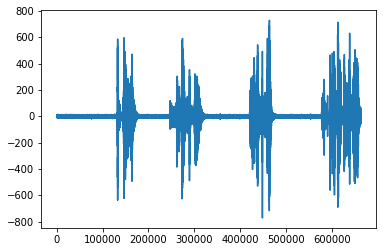

In [9]:
plt.plot(diff.t())

In [10]:
def forward_first_diff(waveform, sample_rate):
    return (waveform[...,:-1]-waveform[...,1:]) * sample_rate

diff = forward_first_diff(waveform, sample_rate)
diff.shape

torch.Size([1, 663022])

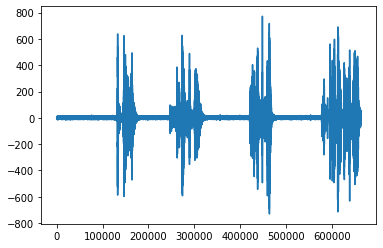

In [11]:
plt.plot(diff.t())

In [12]:
def centered_first_diff(waveform, sample_rate):
    return (waveform[...,2:]-waveform[...,:-2]) * sample_rate / 2.

diff = centered_first_diff(waveform, sample_rate)
diff.shape

torch.Size([1, 663021])

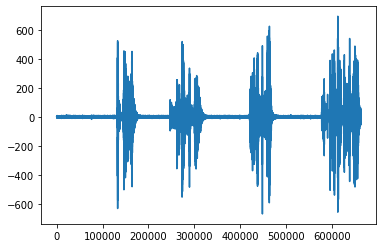

In [13]:
plt.plot(diff.t())

# Deltas?

In [14]:
def compute_deltas(waveform, num_diff=2):
    (waveform[...,2:]-waveform[...,:-2]) * sample_rate / 2.

In [15]:
def compute_deltas(waveform, num_diff=2):

    # TODO replace loop by convolution
    s = torch.zeros(waveform.shape, dtype=waveform.dtype, device=waveform.device)
    for n in range(1,num_diff+1):
        left = torch.nn.ConstantPad1d((n,0), 0)
        right = torch.nn.ConstantPad1d((0,n), 0)
        s += (right(waveform[...,n:])-left(waveform[...,:-n])) * n
    
    # twice sum of integer squared
    denom = num_diff * (num_diff+1) * (2*num_diff+1) / 3

    s /= denom
    
    return s

deltas = compute_deltas(waveform)
deltas.shape

torch.Size([1, 663023])

In [4]:
waveform2 = waveform.repeat(2, 1)

waveform2.shape

torch.Size([2, 663023])

In [5]:
mfcc = torchaudio.transforms.MFCC()

specgram = mfcc(waveform2)
specgram.shape

torch.Size([2, 40, 3316])

In [18]:
# specgram = torch.randn(13, 39, 1021)

In [19]:
#  (channel, freq, time)

In [10]:
specgram

tensor([[[-7.3096e+02, -7.3096e+02, -7.1735e+02,  ..., -5.1697e+02,
          -5.3175e+02, -5.0290e+02],
         [ 5.2458e-06,  5.2458e-06,  1.3515e+01,  ...,  1.3600e+02,
           1.2202e+02,  1.3729e+02],
         [-7.4861e-05, -7.4861e-05,  1.3204e+01,  ...,  9.8696e+00,
           4.6198e+00,  7.2933e+00],
         ...,
         [ 8.0109e-05,  8.0109e-05, -3.1892e-01,  ..., -9.0881e+00,
          -1.0949e+01, -1.1669e+01],
         [-2.0412e-04, -2.0412e-04, -2.4082e+00,  ..., -9.9953e+00,
          -1.0371e+01, -7.6353e+00],
         [-1.8072e-04, -1.8072e-04,  1.3875e+00,  ..., -1.0247e+01,
          -1.3864e+01, -5.6211e+00]],

        [[-7.3096e+02, -7.3096e+02, -7.1735e+02,  ..., -5.1697e+02,
          -5.3175e+02, -5.0290e+02],
         [ 5.2458e-06,  5.2458e-06,  1.3515e+01,  ...,  1.3600e+02,
           1.2202e+02,  1.3729e+02],
         [-7.4861e-05, -7.4861e-05,  1.3204e+01,  ...,  9.8696e+00,
           4.6198e+00,  7.2933e+00],
         ...,
         [ 8.0109e-05,  8

In [11]:
specgram.shape

torch.Size([2, 40, 3316])

In [13]:
torch.nn.functional.pad(specgram, (1,1), mode='replicate')

torch.Size([2, 40, 3318])

In [17]:
torch.arange(-5,5,1, device="cpu")

tensor([-5, -4, -3, -2, -1,  0,  1,  2,  3,  4])

In [15]:
def compute_deltas(specgram, n_diff=2):
    
    assert not specgram.shape[1] % specgram.shape[0]
    
    kernel = (
        torch
        .tensor(range(-n_diff, n_diff+1, 1), device=specgram.device, dtype=specgram.dtype)
        .repeat(specgram.shape[1], specgram.shape[0], 1)
    )
    # print(kernel.shape)
    # print(specgram.shape)
    
    specgram = torch.nn.functional.pad(specgram, (n_diff,n_diff), mode='replicate')
    
    # deltas = torch.nn.functional.conv1d(specgram, kernel, padding=n_diff, groups=specgram.shape[1]//specgram.shape[0])
    deltas = torch.nn.functional.conv1d(specgram, kernel, groups=specgram.shape[1]//specgram.shape[0])

    # twice sum of integer squared
    denom = n_diff * (n_diff+1) * (2*n_diff+1) / 3

    deltas /= denom
    return deltas

compute_deltas(specgram).shape

torch.Size([2, 40, 3316])

In [21]:
specgram.shape

torch.Size([2, 40, 3316])